In [1]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable

# 1. Fetch Nvidia stock data using Yahoo Finance
def load_stock_data(tickers):
    # Downloading Nvidia stock data for the last 7 days with 1-minute intervals
    stock_data = yf.download(tickers, period='10y', interval='1d')
    stock_data = stock_data[['Open', 'High', 'Low', 'Close']]  # Select relevant features
    return stock_data

# Load the stock data
#stock_data = load_stock_data('NVDA')

# 2. Data Preprocessing
def preprocess_data(stock_data, feature='Close', window_size=60):
    # Extract the chosen feature ('Close') from the stock data and scale it
    data = stock_data[[feature]].values
    scaler = MinMaxScaler(feature_range=(0, 1))  # Scale data between 0 and 1
    scaled_data = scaler.fit_transform(data)

    # Prepare training data: input sequences of window_size and target values
    x_train, y_train = [], []
    for i in range(window_size, len(scaled_data)):
        x_train.append(scaled_data[i-window_size:i, 0])
        y_train.append(scaled_data[i, 0])

    # Convert the lists to numpy arrays and reshape for LSTM
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    # Reshape input data to 3D: (samples, time steps, features)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    # Convert numpy arrays to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()
    
    return x_train, y_train, scaler

# Preprocess the data
#window_size = 30  # Use a sequence of 30 days to predict the next price
#x_train, y_train, scaler = preprocess_data(stock_data)

# 3. Define LSTM model using PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define an LSTM layer with num_layers LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer to output the predicted value
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Initialize hidden and cell states (h0, c0) for LSTM layers
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Pass the input data through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the output from the last time step and pass it through the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

# 4. Initialize model, loss function, and optimizer
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
#model = LSTMModel().to(device)  # Initialize model and move to device

#criterion = nn.MSELoss()  # Mean Squared Error loss
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# 5. Train the model
def train_model(model, x_train, y_train, epochs=100, batch_size=64):
    model.train()
    
    for epoch in range(epochs):
        # Batch processing for larger datasets
        for i in range(0, len(x_train), batch_size):
            # Load batches of inputs and targets
            inputs = x_train[i:i+batch_size].to(device)
            targets = y_train[i:i+batch_size].to(device)
            
            # Forward pass: compute predicted y
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            
            # Backward pass: compute gradients
            optimizer.zero_grad()
            loss.backward()
            
            # Update weights
            optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')
    
    return model

# Train the model
#trained_model = train_model(model, x_train, y_train)

# 6. Make predictions
def predict_next_prices(model, stock_data, window_size, scaler, feature='Close'):
    model.eval()  # Set model to evaluation mode
    
    # Get the last 'window_size' minutes of the chosen feature
    last_60_min = stock_data[-window_size:][[feature]].values
    last_60_min_scaled = scaler.transform(last_60_min)  # Scale the data

    # Prepare the input data for prediction
    X_test = np.reshape(last_60_min_scaled, (1, window_size, 1))
    X_test = torch.from_numpy(X_test).float().to(device)

    # Predict the next price using the trained model
    predicted_price_scaled = model(X_test).cpu().detach().numpy()
    predicted_price = scaler.inverse_transform(predicted_price_scaled)  # Rescale to original value
    
    return predicted_price[0][0]

# Predict the next Nvidia stock price
#predicted_price = predict_next_prices(trained_model, stock_data, window_size, scaler)
#print(f"Predicted next Nvidia price: ${predicted_price:.2f}")

# 7. Visualize the stock prices and predictions
def plot_stock_prices(stock, stock_data, scaler, model, window_size, feature='Close'):
    actual_prices = stock_data[feature].values

    model.eval()  # Set model to evaluation mode
    
    # Scale the entire feature data
    model_inputs = stock_data[[feature]].values
    model_inputs = scaler.transform(model_inputs)
    
    # Prepare the data for making predictions
    X_test = []
    for i in range(window_size, len(model_inputs)):
        X_test.append(model_inputs[i-window_size:i, 0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], window_size, 1))
    X_test = torch.from_numpy(X_test).float().to(device)
    
    # Predict the stock prices
    predicted_prices_scaled = model(X_test).cpu().detach().numpy()
    predicted_prices = scaler.inverse_transform(predicted_prices_scaled)
    
    # Plot actual vs predicted prices
    plt.figure(figsize=(14, 7))
    plt.plot(actual_prices, color='black', label=f'Actual {feature} Price')
    plt.plot(np.arange(window_size, len(predicted_prices) + window_size), predicted_prices, color='green', label='Predicted Prices')
    plt.title(f"{stock} Stock Price Prediction with LSTM ({feature})")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

    return predicted_prices 

# Plot the actual vs predicted prices
#predicted_prices = plot_stock_prices(stock_data, scaler, trained_model, window_size)


In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the Close price time series
decomposition = seasonal_decompose(stock_data['Close'], model='additive', period=252)  # Assuming daily data, 252 days in a year

# Plot decomposition
decomposition.plot()
plt.show()

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:

# Calculate RMSE
def calculate_rmse(actual, predicted):
    # Calculate the mean squared error
    mse = np.mean((actual - predicted) ** 2)
    # Take the square root to get RMSE
    rmse = np.sqrt(mse)
    return rmse

# Calculate MAE
def calculate_mae(actual, predicted):
    mae = np.mean(np.abs(actual - predicted))
    return mae


# Compute RMSE
actual_prices = stock_data['Close'].values

min_length = min(len(actual_prices), len(predicted_prices))

# Truncate to the minimum length
actual_prices = actual_prices[:min_length]
predicted_prices = predicted_prices[:min_length]

rmse_value = calculate_rmse(actual_prices, predicted_prices)

# Compute MAE
mae_value = calculate_mae(actual_prices, predicted_prices)
print(f"MAE: {mae_value:.4f}")
print(f"RMSE: {rmse_value:.4f}")


MAE: 8.6655
RMSE: 9.4339


[*********************100%***********************]  1 of 1 completed


Epoch 1/100, Loss: 0.4119
Epoch 11/100, Loss: 0.4046
Epoch 21/100, Loss: 0.0037
Epoch 31/100, Loss: 0.0052
Epoch 41/100, Loss: 0.0036
Epoch 51/100, Loss: 0.0080
Epoch 61/100, Loss: 0.0240
Epoch 71/100, Loss: 0.0210
Epoch 81/100, Loss: 0.0200
Epoch 91/100, Loss: 0.0201
Predicted next NVDA price: $139.84


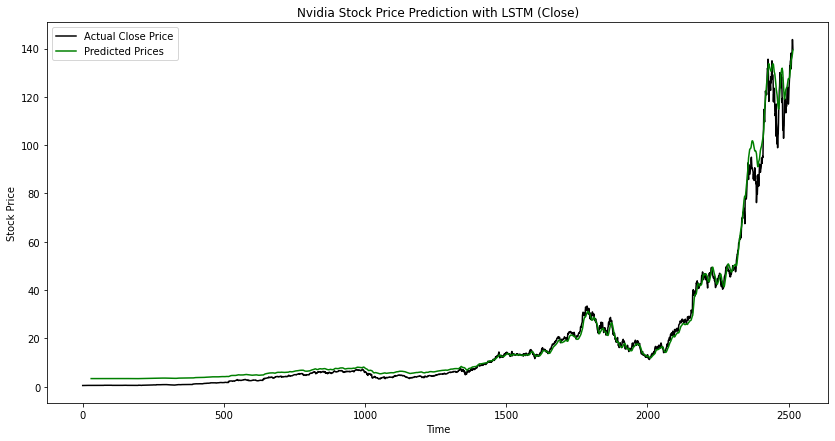

In [ ]:
# Load the stock data
stock = 'NVDA'
stock_data = load_stock_data(stock)
# Preprocess the data
window_size = 30  # Use a sequence of 30 days to predict the next price
x_train, y_train, scaler = preprocess_data(stock_data)
# 4. Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
model = LSTMModel().to(device)  # Initialize model and move to device

criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Train the model
trained_model = train_model(model, x_train, y_train)
# Predict the next Nvidia stock price
predicted_price = predict_next_prices(trained_model, stock_data, window_size, scaler)
print(f"Predicted next {stock} price: ${predicted_price:.2f}")
predicted_prices = plot_stock_prices(stock_data, scaler, trained_model, window_size)

[*********************100%***********************]  1 of 1 completed


Epoch 1/100, Loss: 0.0579
Epoch 11/100, Loss: 0.0020
Epoch 21/100, Loss: 0.0012
Epoch 31/100, Loss: 0.0012
Epoch 41/100, Loss: 0.0011
Epoch 51/100, Loss: 0.0013
Epoch 61/100, Loss: 0.0002
Epoch 71/100, Loss: 0.0003
Epoch 81/100, Loss: 0.0002
Epoch 91/100, Loss: 0.0003
Predicted next MSFT price: $430.32


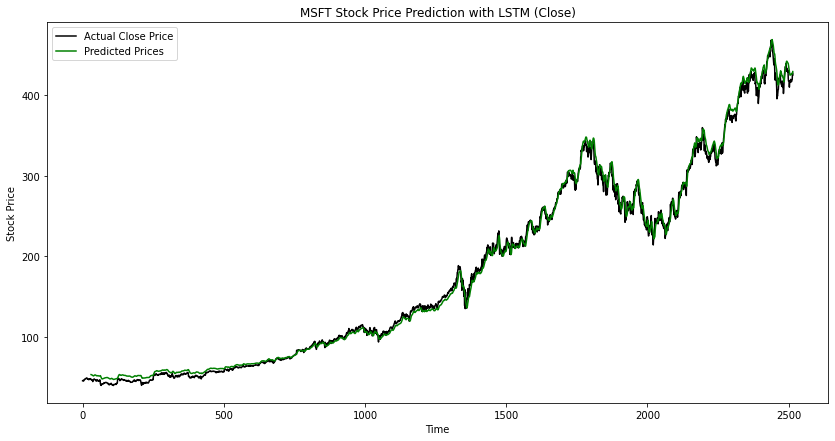

In [ ]:
# Load the stock data
stock = 'MSFT'
stock_data = load_stock_data(stock)
# Preprocess the data
window_size = 30  # Use a sequence of 30 days to predict the next price
x_train, y_train, scaler = preprocess_data(stock_data)
# 4. Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
model = LSTMModel().to(device)  # Initialize model and move to device

criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Train the model
trained_model = train_model(model, x_train, y_train)
# Predict the next Nvidia stock price
predicted_price = predict_next_prices(trained_model, stock_data, window_size, scaler)
print(f"Predicted next {stock} price: ${predicted_price:.2f}")
predicted_prices = plot_stock_prices(stock, stock_data, scaler, trained_model, window_size)